In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np
from scipy import stats
from dieboldmariano import dm_test

In [2]:
df1 = pd.read_csv('hybrid_baseline.csv')
# Convert the Date column to datetime format
#df1['Date'] = pd.to_datetime(df1['Date'], format='%d/%m/%Y')  # Adjust format if needed

# Set Date as index
df1.set_index('Date', inplace=True)

df1 = df1.loc["2014-01-24":]
print(df1.head())

              Actual  Predicted
Date                           
2014-01-24  0.006968   0.005308
2014-01-27  0.006996   0.006956
2014-01-28  0.007142   0.007305
2014-01-29  0.007384   0.007484
2014-01-30  0.007886   0.007653


In [3]:
y_true = df1['Actual']
y_pred_sv_lstm = df1['Predicted']

In [ ]:
df_sv = pd.read_csv('sv.csv')
#df2['Training_End'] = pd.to_datetime(df2['Training_End'], format='%d/%m/%Y')
df_sv.set_index('Training_End', inplace=True)

df_sv = df_sv.loc["2014-01-24":]
print(df_sv.head())

             Training_Start Prediction_Date  SV_Volatility
Training_End                                              
2014-01-24       2012-01-24      2014-01-27       0.006596
2014-01-27       2012-01-25      2014-01-28       0.008759
2014-01-28       2012-01-26      2014-01-29       0.007804
2014-01-29       2012-01-27      2014-01-30       0.007606
2014-01-30       2012-01-30      2014-01-31       0.007602


In [ ]:
df1_reset = df1.reset_index()

# Merge df1 and df2, aligning df1.Date with df2.Prediction_Date
merged_df = pd.merge(df1_reset, df_sv, 
                     left_on='Date', 
                     right_on='Training_End', 
                     how='left')  # 'outer' keeps all dates; use 'left' or 'right' if preferred

# Drop redundant 'Prediction_Date' column (same as 'Date')
#merged_df = merged_df.drop(columns=['Training_End'])

# Optionally set 'Date' back as index
merged_df = merged_df.set_index('Date')

print(merged_df)

              Actual  Predicted Training_Start Prediction_Date  SV_Volatility
Date                                                                         
2014-01-24  0.006968   0.005308     2012-01-24      2014-01-27       0.006596
2014-01-27  0.006996   0.006956     2012-01-25      2014-01-28       0.008759
2014-01-28  0.007142   0.007305     2012-01-26      2014-01-29       0.007804
2014-01-29  0.007384   0.007484     2012-01-27      2014-01-30       0.007606
2014-01-30  0.007886   0.007653     2012-01-30      2014-01-31       0.007602
...              ...        ...            ...             ...            ...
2024-12-20  0.008064   0.008378     2022-12-20      2024-12-23       0.008988
2024-12-23  0.008165   0.008781     2022-12-21      2024-12-24       0.009003
2024-12-24  0.008477   0.008465     2022-12-22      2024-12-26       0.008722
2024-12-26  0.008472   0.008382     2022-12-23      2024-12-27       0.008790
2024-12-27  0.008756   0.008810     2022-12-27      2024-12-30  

In [6]:
y_pred_sv=merged_df['SV_Volatility']


# 2. Calculate absolute errors (can also use squared errors)
error_sv_lstm = abs(y_true - y_pred_sv_lstm)
error_sv = abs(y_true - y_pred_sv)

# 3. Compute the difference in errors
error_diff = error_sv_lstm - error_sv

# 4. Perform Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(error_diff)

print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value:.20f}")

if p_value < 0.05:
    print("Significant difference between SV-LSTM and SV forecasts.")
else:
    print("No significant difference between the models.")

Wilcoxon test statistic: 266472.0
P-value: 0.00000000000000000000
Significant difference between SV-LSTM and SV forecasts.


In [12]:
# Sample size (after removing zero diffs)
n = np.count_nonzero(error_diff)

# Mean and standard deviation under H0
mu = n * (n + 1) / 4
sigma = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    # Compute z-score
z_score = (stat - mu) / sigma
print(f"Z-score: {z_score:.4f}")

Z-score: -36.4546


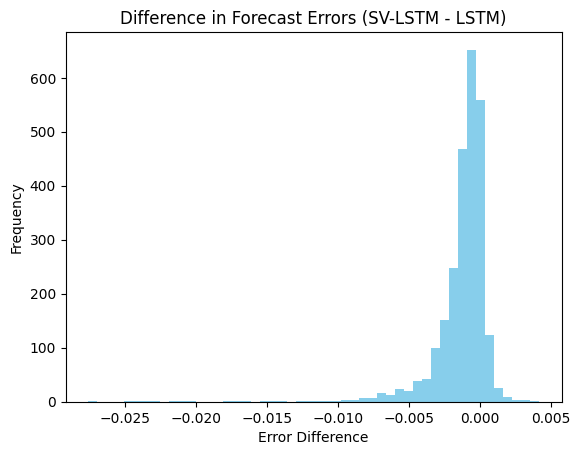

In [37]:
import matplotlib.pyplot as plt

plt.hist(error_diff, bins=50, color='skyblue')
plt.title('Difference in Forecast Errors (SV-LSTM - LSTM)')
plt.xlabel('Error Difference')
plt.ylabel('Frequency')
plt.show()

In [17]:
def diebold_mariano(e1, e2, h=1, power=2):
    """
    e1, e2: forecast errors from two models
    h: forecast horizon
    power: loss function power (2 = MSE, 1 = MAE)
    """
    d = np.abs(e1) ** power - np.abs(e2) ** power  # loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    DM_stat = mean_d / np.sqrt((var_d / len(d)))
    p_value = 2 * stats.norm.cdf(-abs(DM_stat))
    return DM_stat, p_value

In [51]:
# Apply Diebold-Mariano test
dm_stat, dm_p = diebold_mariano(error_sv_lstm, error_sv, h=1, power=2)
print(f"Diebold-Mariano statistic: {dm_stat:.4f}, p-value: {dm_p:.8f}")

Diebold-Mariano statistic: -9.1790, p-value: 0.00000000


In [39]:
ks_stat, ks_p = stats.ks_2samp(y_pred_sv_lstm, error_sv)
print(f"Kolmogorov-Smirnov statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

Kolmogorov-Smirnov statistic: 0.8693, p-value: 0.0000


In [53]:
# Apply Diebold-Mariano test
dm_stat3, dm_p3 = diebold_mariano(error_sv_lstm, error_sv, h=1, power=1)
print(f"Diebold-Mariano statistic: {dm_stat3:.4f}, p-value: {dm_p3:.8f}")

Diebold-Mariano statistic: -29.1385, p-value: 0.00000000


In [41]:
dm_stat4, dm_p4 = diebold_mariano(error_sv_lstm, error_sv, h=1, power=1)  # Absolute error
print(f"DM Statistic (MAE): {dm_stat4:.4f}, P-value: {dm_p4:.8f}")


DM Statistic (MAE): -29.1385, P-value: 0.00000000


In [42]:
dm_test, dm_p2 = dm_test(y_true, y_pred_sv_lstm, error_sv, one_sided=True)
print(f"Diebold-Mariano Test Statistic: {dm_test}")
print(f"P-value: {dm_p2}")

Diebold-Mariano Test Statistic: -23.58630765424515
P-value: 1.0867441086627264e-111


In [45]:
mse_sv = np.mean((y_true - y_pred_sv) ** 2)
mse_sv_lstm = np.mean((y_true - y_pred_sv_lstm) ** 2)
print(f"MSE LSTM: {mse_lstm}, MSE SV-LSTM: {mse_sv_lstm}")


MSE LSTM: 8.718939336059138e-06, MSE SV-LSTM: 5.071173179974377e-07


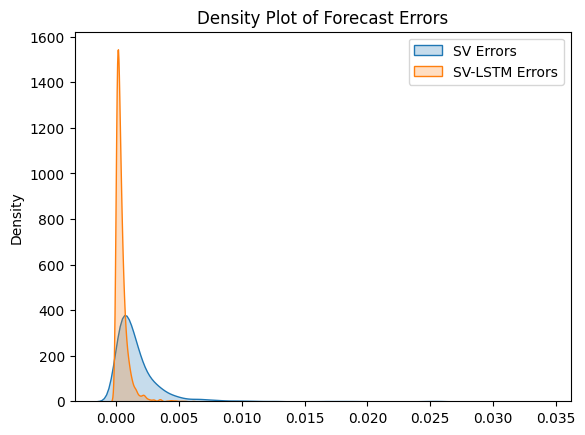

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(error_sv, label="SV Errors", fill=True)
sns.kdeplot(error_sv_lstm, label="SV-LSTM Errors", fill=True)
plt.legend()
plt.title("Density Plot of Forecast Errors")
plt.show()


In [48]:

# Define functions
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Compute error metrics
mse_lstm = mse(y_true, y_pred_sv)
mae_lstm = mae(y_true, y_pred_sv)
mape_lstm = mape(y_true, y_pred_sv)

mse_sv_lstm = mse(y_true, y_pred_sv_lstm)
mae_sv_lstm = mae(y_true, y_pred_sv_lstm)
mape_sv_lstm = mape(y_true, y_pred_sv_lstm)

# Display results in scientific notation

def sci_format(val):
    return f"{val:.2e}".replace("e-0", "e-").replace("e+", "e")

def format_as_10(val):
    # Convert to scientific notation like: 1.29 * 10^(-5)
    base, exp = f"{val:.2e}".split('e')
    return f"{base} × 10^{int(exp)}"

# Display results
print("LSTM Model:")
print(f"MSE: {format_as_10(mse_lstm)}")
print(f"MAE: {format_as_10(mae_lstm)}")

print("\nSV-LSTM Model:")
print(f"MSE: {format_as_10(mse_sv_lstm)}")
print(f"MAE: {format_as_10(mae_sv_lstm)}")

LSTM Model:
MSE: 8.72 × 10^-6
MAE: 1.72 × 10^-3

SV-LSTM Model:
MSE: 5.07 × 10^-7
MAE: 4.29 × 10^-4
